In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pymc as pm
import pytensor
from matplotlib import pyplot as plt
from pytensor import tensor as pt
from pytensor.scan import until
from pytensor.tensor import random as ptr

In [3]:
seed = 42
def rng_ctor(seed_seq):
    return np.random.Generator(np.random.Philox(seed_seq))

rng = ptr.RandomStream(seed=seed, rng_ctor=rng_ctor)
rng.normal().eval()

array(-1.33507789)

In [4]:
def create_gaussian_particles(n_particles, mean=0, std=1):
    mean, std = pt.broadcast_arrays(mean, std)
    particles = rng.normal(loc=mean, scale=std, size=(n_particles, 3))
    particles = pt.set_subtensor(particles[:, 2], particles[:, 2] % (2 * np.pi))
    return particles


def temporal_evolution(
    heading_change, velocity, particles, heading_noise, velocity_noise, dt
):
    """move according to control input (heading change, velocity)
    with noise (std heading change, std velocity)`"""

    N = particles.shape[0]
    # update heading
    particles = pt.inc_subtensor(
        particles[:, 2], heading_change + rng.normal(size=N) * heading_noise
    )
    particles = pt.set_subtensor(particles[:, 2], particles[:, 2] % (2 * np.pi))

    # move in the (noisy) commanded direction
    dist = (velocity * dt) + (pm.HalfNormal.dist(size=N) * velocity_noise)
    particles = pt.inc_subtensor(particles[:, 0], pt.cos(particles[:, 2]) * dist)
    particles = pt.inc_subtensor(particles[:, 1], pt.sin(particles[:, 2]) * dist)
    return particles


def distances2(positions, landmarks):
    # positions.shape (n_particles, dim)
    # landmarks.shape (n_landmarks, dim)
    # out.shape (n_particles, n_landmarks)
    rel = positions[:, None, :] - landmarks[None, :, :]
    return (rel**2).sum(axis=-1)


def distances(positions, landmarks):
    return pt.sqrt(distances2(positions, landmarks))


def update_weights(log_weights, particles, observed, sensor_noise, landmarks):
    dist_to_land = distances(particles[..., :2], landmarks)
    log_weights += pm.logprob.logp(
        pm.Normal.dist(dist_to_land, sensor_noise), observed
    ).sum(axis=-1)

    log_weights -= pt.logsumexp(log_weights)
    return log_weights


def estimate(particles, log_weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[..., :2]
    mean = pt.sum(pos * pt.exp(log_weights)[..., None], axis=-2) / pt.exp(
        log_weights[..., None]
    ).sum(axis=-2)
    var = pt.sum(
        (pos - mean[..., None, :]) ** 2 * pt.exp(log_weights)[..., None], axis=-2
    ) / pt.exp(log_weights[..., None]).sum(axis=-2)
    return mean, pt.sqrt(var)


def neff(log_weights):
    return 1 / pt.sum(pt.exp(log_weights) ** 2)


def systematic_resample(particles, log_weights, n_particles):
    # make n_particles subdivisions, and choose positions with a
    # consistent random offset
    n_particles = n_particles.eval()
    positions = (rng.uniform() + pt.arange(n_particles)) / n_particles

    weights = pt.exp(log_weights)
    cumulative_sum = pt.cumsum(weights)
    indexes = pytensor.shared(np.zeros(n_particles, dtype="int"))
    i = pytensor.shared(np.array([0]))
    j = pytensor.shared(np.array([0]))

    def step(indexes, i, j, positions, cumulative_sum):
        ii = i[0]
        jj = j[0]
        increments = pt.switch(positions[ii] < cumulative_sum[jj], [1, 0], [0, 1])
        indexes_update = pt.set_subtensor(indexes[ii], jj)
        i_update = i + increments[0]
        j_update = j + increments[1]
        return (
            [],
            {indexes: indexes_update, i: i_update, j: j_update},
            until(pt.ge(ii, n_particles - 1)),
        )

    _, updates = pytensor.scan(
        step,
        non_sequences=[indexes, i, j, positions, cumulative_sum],
        n_steps=n_particles**2,
    )
    inds = updates[indexes]
    return particles[inds], pt.full(
        n_particles, -np.log(n_particles), dtype=log_weights.dtype
    )


def no_resample(particles, log_weights):
    return particles, log_weights


def particle_filter(
    observed_distances,
    landmarks,
    heading_changes,
    velocities,
    heading_noise,
    velocity_noise,
    sensor_noise,
    dt=1.0,
    n_particles=1000,
    initial_particles=None,
):
    if initial_particles is None:
        initial_particles = create_gaussian_particles(n_particles=n_particles)

    initial_weights = -pt.ones(n_particles) * np.log(n_particles)

    def step(heading_change, velocity, observed_distance, particles, log_weights):
        particles = temporal_evolution(
            particles=particles,
            heading_change=heading_change,
            velocity=velocity,
            heading_noise=heading_noise,
            velocity_noise=velocity_noise,
            dt=dt,
        )

        # incorporate measurements
        log_weights = update_weights(
            particles=particles,
            log_weights=log_weights,
            observed=observed_distance,
            sensor_noise=sensor_noise,
            landmarks=landmarks,
        )

        # resample if too few effective particles
        particles, log_weights = pytensor.ifelse(
            neff(log_weights) < n_particles / 2,
            systematic_resample(
                particles=particles,
                log_weights=log_weights,
                n_particles=pt.as_tensor_variable(n_particles),
            ),
            no_resample(particles, log_weights),
        )
        return particles, log_weights

    [particles, weights], _ = pytensor.scan(
        step,
        sequences=[
            pt.as_tensor_variable(heading_changes),
            pt.as_tensor_variable(velocities),
            pt.as_tensor_variable(observed_distances),
        ],
        outputs_info=[
            initial_particles,
            initial_weights,
        ],
    )
    return particles, weights

In [5]:
landmarks = np.array([[-1, 2], [5, 10], [12, 14], [18, 21]])
heading_noise = 0.05
velocity_noise = 0.2
sensor_noise = 0.1
dt = 0.1

initial_position = np.array([0, 0, np.pi / 4])
n_time = 30
intended_headings = np.deg2rad(6 * np.sin(np.linspace(0, 2 * np.pi, n_time)))
max_speed = 5
intended_velocities = np.concatenate(
    [
        np.linspace(0, max_speed, n_time // 3),
        np.full(n_time - 2 * (n_time // 3), max_speed),
        np.linspace(max_speed, 0, n_time // 3),
    ],
)

In [6]:
true_positions, _ = pytensor.scan(
    temporal_evolution,
    outputs_info=[pt.as_tensor_variable([initial_position])],
    sequences=[
        pt.as_tensor_variable(intended_headings),
        pt.as_tensor_variable(intended_velocities),
    ],
    non_sequences=[heading_noise, velocity_noise, dt],
)
true_positions = true_positions[:, 0].eval()

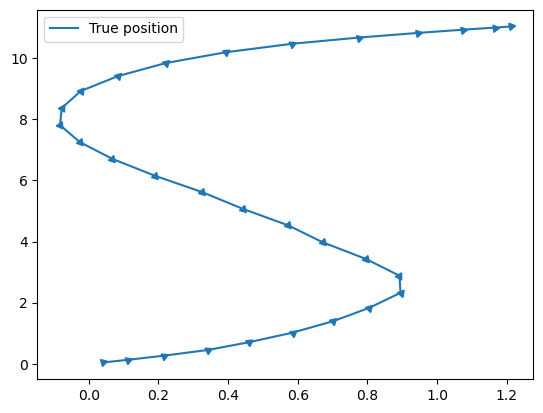

In [7]:
plt.plot(true_positions[:, 0], true_positions[:, 1], color="C0", label="True position")
for true_position in true_positions:
    plt.plot(
        true_position[0],
        true_position[1],
        marker=(3, 0, np.rad2deg(true_position[2])),
        color="C0",
    )
plt.legend();

In [8]:
observed_distances = distances(true_positions[..., :2], landmarks)

In [9]:
particles, log_weights = particle_filter(
    observed_distances=observed_distances,
    landmarks=landmarks,
    heading_changes=intended_headings,
    velocities=intended_velocities,
    heading_noise=heading_noise,
    velocity_noise=velocity_noise,
    sensor_noise=sensor_noise,
    dt=dt,
    n_particles=1000,
    initial_particles=None,
)

In [10]:
estimate_mean, estimate_std = estimate(particles, log_weights)

func = pytensor.function([], [estimate_mean, estimate_std, particles, log_weights])
mean, std, parts, lws = func()

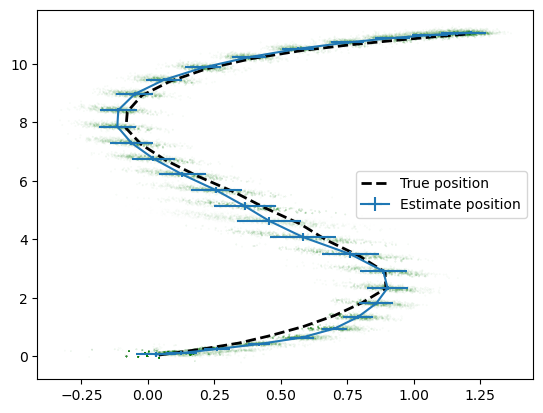

In [11]:
plt.plot(
    true_positions[:, 0],
    true_positions[:, 1],
    ls="--",
    lw=2,
    color="k",
    label="True position",
)
plt.errorbar(
    mean[:, 0], mean[:, 1], std[:, 0], std[:, 1], color="C0", label="Estimate position"
)
plt.scatter(parts[..., 0], parts[..., 1], c="green", s=np.exp(lws) * 100, alpha=0.05)
plt.legend();